# MSD Feature Selection

This notebook demonstrates Marginal Somers' D (MSD) based feature selection using rank correlation (Somers' D) instead of traditional WOE-based Information Value.

**Note on Terminology**: For binary classification, Somers' D equals the Gini coefficient (2 × AUC - 1). The functions in this notebook use Somers' D, which works for both binary and continuous targets, while Gini is specific to binary classification.


In [ ]:
from pathlib import Path
from typing import Any

import pandas as pd
from sklearn.model_selection import train_test_split

from fastwoe import FastWoe
from fastwoe.metrics import somersd_yx
from fastwoe.screening import marginal_somersd_selection

## Load and Prepare Data

We'll use the Bank Case Study dataset to demonstrate MSD feature selection.


In [6]:
ROOT_DIR = Path.cwd().parent
df = pd.read_csv(ROOT_DIR / "data" / "BankCaseStudyData.csv")

label = "Final_Decision"
df[label] = df[label].map({"Accept": 0, "Decline": 1})

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list[Any](df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (24859, 33)

Columns: ['Account_Number', 'Account_Type', 'Final_Decision', 'Current_Delinquency_status', 'Application_Date', 'Application_Score', 'Cheque_Card_Flag', 'Existing_Customer_Flag', 'Gross_Annual_Income', 'Home_Telephone_Number', 'Insurance_Required', 'Loan_Amount', 'Loan_Payment_Frequency', 'Loan_Payment_Method', 'Marital_Status', 'Number_of_Dependants', 'Number_of_Payments', 'Occupation_Code', 'Promotion_Type', 'Residential_Status', 'Time_at_Address', 'Time_in_Employment', 'Time_with_Bank', 'Weight_Factor', 'GB_Flag', 'Age_of_Applicant', 'Application_Month', 'Bureau_Score', 'SP_ER_Reference', 'SP_Number_Of_Searches_L6M', 'SP_Number_of_CCJs', 'Loan_to_income', 'split']

First few rows:


,Account_Number,Account_Type,Final_Decision,Current_Delinquency_status,Application_Date,Application_Score,Cheque_Card_Flag,Existing_Customer_Flag,Gross_Annual_Income,Home_Telephone_Number,...,Weight_Factor,GB_Flag,Age_of_Applicant,Application_Month,Bureau_Score,SP_ER_Reference,SP_Number_Of_Searches_L6M,SP_Number_of_CCJs,Loan_to_income,split
0,10730734532,FL,0,NaN,20061206,965,Y,Y,12000,N,...,2.0,NTU,28,200612,1009,2,0,0,15.50,Development
1,10803550208,VL,1,NaN,20060928,720,N,Y,10015,Y,...,2.0,Rejects,36,200609,784,3,0,0,29.96,Development
2,10769083290,FL,0,0.0,20060721,975,Y,N,11000,Y,...,2.0,Good,48,200607,940,1,2,0,45.45,Development
3,10072636331,FL,0,1.0,20060529,960,Y,N,16500,Y,...,2.0,Good,41,200605,902,1,1,0,31.82,Development
4,10737329597,FL,0,0.0,20060718,980,Y,Y,60000,Y,...,2.0,Good,37,200607,1013,1,7,0,16.67,Development


In [7]:
# Select categorical features for feature selection
categorical_features = [
    "Account_Type",
    "Cheque_Card_Flag",
    "Existing_Customer_Flag",
    "Home_Telephone_Number",
    "Insurance_Required",
    "Loan_Payment_Frequency",
    "Loan_Payment_Method",
    "Marital_Status",
    "Occupation_Code",
    "Promotion_Type",
    "Residential_Status",
]
numerical_features = [
    "Gross_Annual_Income",
    "Number_of_Dependants",
    "Time_at_Address",
    "Time_in_Employment",
    "Time_with_Bank",
    "Age_of_Applicant",
    # "Bureau_Score",
    "Application_Score",
    "SP_Number_Of_Searches_L6M",
    "SP_Number_of_CCJs",
    "Loan_to_income",
]

# Filter to features that exist and have reasonable cardinality
# available_features = [f for f in categorical_features if f in df.columns]
available_features = categorical_features + numerical_features
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())

print(f"Available categorical features: {available_features}")

# Check cardinality
for feat in available_features:
    n_unique = df[feat].nunique()
    print(f"{feat}: {n_unique} unique values")

Available categorical features: ['Account_Type', 'Cheque_Card_Flag', 'Existing_Customer_Flag', 'Home_Telephone_Number', 'Insurance_Required', 'Loan_Payment_Frequency', 'Loan_Payment_Method', 'Marital_Status', 'Occupation_Code', 'Promotion_Type', 'Residential_Status', 'Gross_Annual_Income', 'Number_of_Dependants', 'Time_at_Address', 'Time_in_Employment', 'Time_with_Bank', 'Age_of_Applicant', 'Application_Score', 'SP_Number_Of_Searches_L6M', 'SP_Number_of_CCJs', 'Loan_to_income']
Account_Type: 2 unique values
Cheque_Card_Flag: 2 unique values
Existing_Customer_Flag: 2 unique values
Home_Telephone_Number: 2 unique values
Insurance_Required: 2 unique values
Loan_Payment_Frequency: 4 unique values
Loan_Payment_Method: 4 unique values
Marital_Status: 5 unique values
Occupation_Code: 4 unique values
Promotion_Type: 4 unique values
Residential_Status: 4 unique values
Gross_Annual_Income: 2316 unique values
Number_of_Dependants: 12 unique values
Time_at_Address: 479 unique values
Time_in_Employ

In [8]:
# Prepare feature matrix (only categorical features for now)
X = df[available_features].copy()
y = df[label].values

# Remove rows with too many missing values
missing_threshold = 0.5
valid_mask = (X.isna().sum(axis=1) / len(X.columns)) < missing_threshold
X = X[valid_mask].copy()
y = y[valid_mask]

print(f"Final dataset shape: {X.shape}")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")
print(f"Bad rate: {y.mean():.2%}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain: {len(X_train)}, Test: {len(X_test)}")

Final dataset shape: (24859, 21)
Target distribution: {0: 22262, 1: 2597}
Bad rate: 10.45%

Train: 17401, Test: 7458


## Understanding Marginal Somers' D Selection

The `marginal_somersd_selection` function implements truly marginal feature selection:

1. **Step 1**: Selects the feature with highest univariate Somers' D with the target
2. **Step 2+**: For each subsequent step:
   - Fits a model with currently selected features
   - Computes residuals: ε = y - model.predict_proba(X[selected])
   - Measures Somers' D between each remaining feature and the residuals
   - Selects the feature with highest |Somers' D(ε, feature)|
   - Skips features with high correlation to already-selected features

**Key concept**: The algorithm relies on **rankable variance** in residuals - the portion of residual variance that can be captured by rank correlation (monotonic relationships). Features are selected based on their ability to explain rankable patterns in residuals that the current model misses.

This makes it truly "marginal" - each feature's contribution is measured relative to what prior features fail to explain.


In [ ]:
# Run marginal Somers' D feature selection (always residual-based)
result = marginal_somersd_selection(
    X_train,
    y_train,
    X_test=X_test,
    y_test=y_test,
    min_msd=0.01,
    max_features=10,
    correlation_threshold=0.6,
    ties="y",
    random_state=42,
)

# Compute actual model Somers' D
pred = result["model"].predict_proba(X_train[result["selected_features"]])[:, 1]
model_somersd = somersd_yx(y_train, pred).statistic
print(f"Gini: {model_somersd:.2%}")

Gini: 71.25%


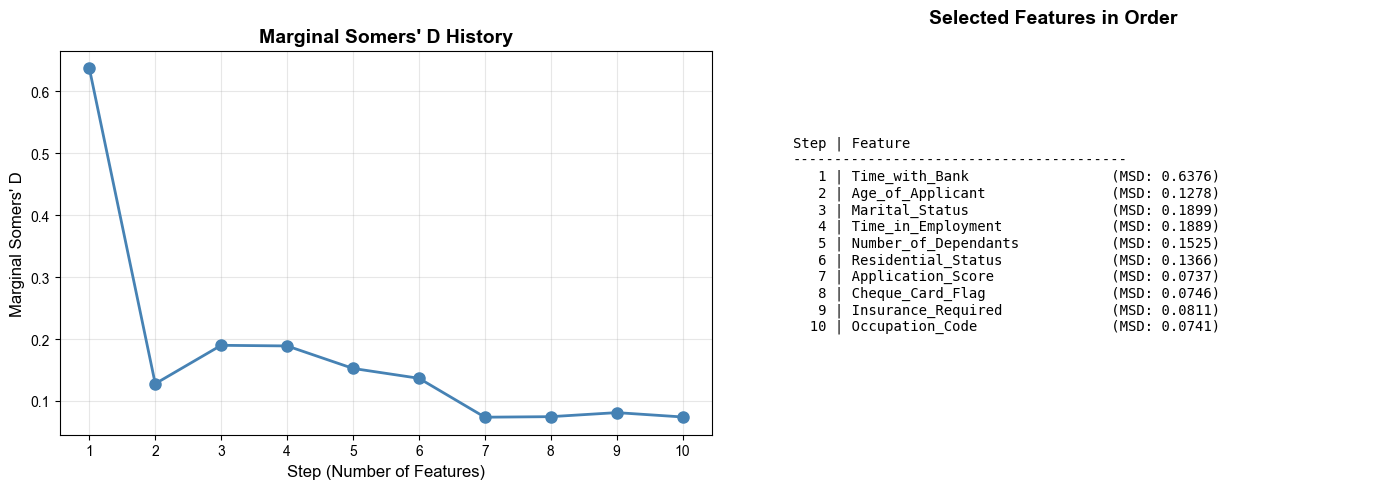


SUMMARY
Model Somers' D (train): 0.7125
Model Somers' D (test): 0.7111

Marginal MSD of last feature: 0.0741
(This is the MSD of the last feature with residuals, not the model's overall MSD)


In [11]:
# Visualize the selection process
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MSD history
ax1 = axes[0]
steps = range(1, len(result["msd_history"]) + 1)
ax1.plot(steps, result["msd_history"], "o-", linewidth=2, markersize=8, color="steelblue")
ax1.set_xlabel("Step (Number of Features)", fontsize=12)
ax1.set_ylabel("Marginal Somers' D", fontsize=12)
ax1.set_title("Marginal Somers' D History", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.set_xticks(steps)

# Plot 2: Feature selection order
ax2 = axes[1]
ax2.axis("off")
ax2.set_title("Selected Features in Order", fontsize=14, fontweight="bold", pad=20)

table_text = "Step | Feature\n"
table_text += "-" * 40 + "\n"
for i, feat in enumerate(result["selected_features"], 1):
    msd = result["msd_history"][i - 1]
    table_text += f"{i:4d} | {feat:30s} (MSD: {msd:.4f})\n"

ax2.text(
    0.1,
    0.5,
    table_text,
    fontfamily="monospace",
    fontsize=10,
    verticalalignment="center",
    transform=ax2.transAxes,
)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Model Somers' D (train): {model_somersd:.4f}")
if len(result["test_performance"]) > 0:
    print(f"Model Somers' D (test): {result['test_performance'][-1]:.4f}")
print(f"\nMarginal MSD of last feature: {result['msd_history'][-1]:.4f}")
print("(This is the MSD of the last feature with residuals, not the model's overall MSD)")

## Run MSD Feature Selection

Now we'll run the MSD feature selection using Somers' D rank correlation.


In [21]:
# Run MSD feature selection with verbose logging
# Set verbose=True to see detailed pairwise outputs and step-by-step information
result = marginal_somersd_selection(
    X_train,
    y_train,
    X_test=X_test,
    y_test=y_test,
    min_msd=0.01,  # Minimum marginal Somers' D threshold
    max_features=10,  # Maximum number of features to select
    correlation_threshold=0.6,  # Maximum correlation between features
    ties="y",
    random_state=42,
)

print(f"Features: {result['selected_features']}")

Features: ['Time_with_Bank', 'Age_of_Applicant', 'Marital_Status', 'Time_in_Employment', 'Number_of_Dependants', 'Residential_Status', 'Application_Score', 'Cheque_Card_Flag', 'Insurance_Required', 'Occupation_Code']


## Using the Final Model with Selected Features

The feature selection returns a trained FastWoe model that can be used directly for predictions. Here's how to use it:


In [22]:
final_model = result["model"]
selected_features = result["selected_features"]

print(f"Selected {len(selected_features)} features:")
for i, feat in enumerate[Any](selected_features, 1):
    print(f"{i}. {feat}")

# The model is already trained and ready to use
print(f"\nModel is fitted: {final_model.is_fitted_}")
# FastWoe stores features in mappings_ dictionary
print(f"Model features: {list[Any](final_model.mappings_.keys())}")

Selected 10 features:
1. Time_with_Bank
2. Age_of_Applicant
3. Marital_Status
4. Time_in_Employment
5. Number_of_Dependants
6. Residential_Status
7. Application_Score
8. Cheque_Card_Flag
9. Insurance_Required
10. Occupation_Code

Model is fitted: True
Model features: ['Time_with_Bank', 'Age_of_Applicant', 'Marital_Status', 'Time_in_Employment', 'Number_of_Dependants', 'Residential_Status', 'Application_Score', 'Cheque_Card_Flag', 'Insurance_Required', 'Occupation_Code']


## Adding Custom Features to the Model

You can add custom features to the selected model by:

1. Creating a new FastWoe model with additional features
2. Using a custom FastWoe configuration
3. Manually selecting features to include


In [23]:
# Create a custom FastWoe model with specific parameters
custom_woe_config = FastWoe(
    binning_method="faiss_kmeans",
    random_state=42,
)

# Use it in feature selection with verbose logging
result_custom = marginal_somersd_selection(
    X_train,
    y_train,
    X_test=X_test,
    y_test=y_test,
    min_msd=0.01,
    max_features=10,
    correlation_threshold=0.6,
    ties="y",
    random_state=42,
    woe_model=custom_woe_config,  # Pass custom configuration
    verbose=True,  # Enable detailed logging
)

print(f"Custom config selected {len(result_custom['selected_features'])} features")
print(f"Features: {result_custom['selected_features']}")

2025-12-14 21:03:25.469 | INFO     | fastwoe.screening:log_or_print:204 - Pre-computing WOE values for all features...
2025-12-14 21:03:25.768 | INFO     | fastwoe.screening:log_or_print:204 - Building pairwise feature correlation matrix using Somers' D...
2025-12-14 21:03:25.770 | DEBUG    | fastwoe.screening:_build_feature_correlation_matrix:77 - Pairwise correlation [Account_Type ↔ Cheque_Card_Flag]: Somers' D = 0.0560 (ij=0.0581, ji=0.0539)
2025-12-14 21:03:25.772 | DEBUG    | fastwoe.screening:_build_feature_correlation_matrix:77 - Pairwise correlation [Account_Type ↔ Existing_Customer_Flag]: Somers' D = 0.0256 (ij=0.0153, ji=0.0359)
2025-12-14 21:03:25.774 | DEBUG    | fastwoe.screening:_build_feature_correlation_matrix:77 - Pairwise correlation [Account_Type ↔ Home_Telephone_Number]: Somers' D = 0.0664 (ij=0.0175, ji=0.1153)
2025-12-14 21:03:25.776 | DEBUG    | fastwoe.screening:_build_feature_correlation_matrix:77 - Pairwise correlation [Account_Type ↔ Insurance_Required]: Some

Custom config selected 10 features
Features: ['Application_Score', 'SP_Number_Of_Searches_L6M', 'Occupation_Code', 'Loan_Payment_Frequency', 'Gross_Annual_Income', 'Loan_Payment_Method', 'Cheque_Card_Flag', 'Insurance_Required', 'Residential_Status', 'Marital_Status']
